In [ ]:
command = [['STOP sign', 'bring vehicle to halt'], ['NO ENTRY sign', "the vehicle can't enter"], ['NO LEFT TURN sign','the vehicle should not take a left turn'],['NO RIGHT TURN','the vehicle should not take a right turn'],['NO U-TURN','the vehicle should not take an u-turn',['SPEED LIMIT','the vehicle should not drive faster than that limit',['NO PARKING','the vehicle is not allow not park in that area']]]]

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! kaggle datasets list
!kaggle datasets download -d andrewmvd/road-sign-detection
!unzip road-sign-detection.zip
!rm road-sign-detection.zip

In [ ]:
import os
import xml.etree.ElementTree as ET
from pathlib import Path
import pandas as pd
from PIL import Image

In [ ]:
!mkdir resized_images

In [ ]:
#resize image to 224*224
def resize_image(image, size):
    """Resize an image to the given size."""
    return image.resize(size, Image.ANTIALIAS)


def resize_images(input_dir, output_dir, size):
    """Resize the images in 'input_dir' and save into 'output_dir'."""    
    images = os.listdir(input_dir)
    n_images = len(images)
    for iimage, image in enumerate(images): 
      try:
        with open(os.path.join(input_dir, image), 'r+b') as f:
            with Image.open(f) as img:
                img = resize_image(img, size)
                img.save(os.path.join(output_dir, image), img.format)
                  
      except(IOError, SyntaxError) as e:
        pass

In [ ]:
IMAGE_PATH = "/content/images"
RESIZE_IMAGE_PATH = "/content/resized_images"
ANNOTATIONS_PATH = "/content/annotations"
image_size = [224, 224]

In [ ]:
import torch.nn as nn
import torchvision.models as models
import torch


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
resize_images(IMAGE_PATH, RESIZE_IMAGE_PATH, image_size)

In [ ]:
# makes a list of all the paths of the files under annotations
def filelist(root, file_type):
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

# makes train data with image and class of images
def train_df (ANNOTATIONS_PATH):
    annotations = filelist(ANNOTATIONS_PATH , '.xml')
    anno_list = []
    for path in annotations:
      root = ET.parse(path).getroot()
      anno = {}
      anno['filename'] = Path(str(RESIZE_IMAGE_PATH) + '/'+ root.find("./filename").text)
      anno['class'] = root.find("./object/name").text
      anno_list.append(anno)
    
    return pd.DataFrame(anno_list)
    

In [ ]:
train_data = train_df(ANNOTATIONS_PATH)

In [ ]:
#assigning indices to classes
class_dict = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}
train_data['class'] = train_data['class'].apply(lambda x:  class_dict[x])

In [ ]:
train_data.head()

,filename,class
0,/content/resized_images/road414.png,0
1,/content/resized_images/road92.png,1
2,/content/resized_images/road681.png,0
3,/content/resized_images/road200.png,2
4,/content/resized_images/road163.png,0


In [ ]:
embed_size = 1024
no_classes = len(class_dict)

In [ ]:
class Model(nn.Module):

    def __init__(self, embed_size):
        super(Model, self).__init__()
        model = models.vgg19(pretrained=True)
        in_features = model.classifier[-1].in_features  # input size of feature vector
        model.classifier = nn.Sequential(
            *list(model.classifier.children())[:-1])    # remove last fc layer
        self.model = model                              # loaded model without last fc layer
        self.fc1 = nn.Linear(in_features, embed_size)    # feature vector of image
        self.fc2 = nn.Linear(embed_size, 256)
        self.fc3 = nn.Linear(256, no_classes)
        self.tanh = nn.Tanh()

    def forward(self, image):
        with torch.no_grad():
            img_feature = self.model(image)                  # [batch_size, vgg16(19)_fc=4096]
        out = self.fc1(img_feature)                   # [batch_size, embed_size]
        out = self.fc2(self.tanh(out))
        out = self.fc3(self.tanh(out))

        # l2_norm = img_feature.norm(p=2, dim=1, keepdim=True).detach()
        # img_feature = img_feature.div(l2_norm)               # l2-normalized feature vector
        return out

In [ ]:
model = Model(embed_size).to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
learning_rate = 0.001
step_size = 10
gamma = 0.1
num_epochs = 6
num_workers = 8
save_step = 1
num_data = len(train_data['class'])

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
import numpy as np

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.485, 0.456, 0.406),
                                                        (0.229, 0.224, 0.225))])
        

for epoch in range(num_epochs):
  correct = 0
  scheduler.step()
  model.train()
  
  for i in range(num_data):
    img = Image.open(train_data['filename'][i]).convert('RGB')
    img = transform(img)
    img = img.unsqueeze(0)
    img = img.to(device)

    label = torch.tensor(train_data['class'][i])
    label = label.unsqueeze(0)
    label = label.to(device)
    optimizer.zero_grad()

    with torch.set_grad_enabled(True):
      output = model(img)
      _, pred = torch.max(output, 1)
      loss = criterion(output, label)
      loss.backward()
      optimizer.step()

    correct += torch.stack([label == pred]).sum()

  print("Accuracy: ", correct/num_data, "Epoch", epoch)

Accuracy:  tensor(0.8985, device='cuda:0') Epoch 0
Accuracy:  tensor(0.8826, device='cuda:0') Epoch 1
Accuracy:  tensor(0.8974, device='cuda:0') Epoch 2
Accuracy:  tensor(0.9111, device='cuda:0') Epoch 3
Accuracy:  tensor(0.9065, device='cuda:0') Epoch 4
Accuracy:  tensor(0.9008, device='cuda:0') Epoch 5


In [ ]:
def road_sign_detection(sign_path, size):
  with open(sign_path, 'r+b') as f:
    with Image.open(f) as img:
      img = resize_image(img, size)
  
  img.show()
  img = transform(img)
  img = img.unsqueeze(0)
  img = img.to(device)
  output = model(img)
  _, pred = torch.max(output, 1)
  print(list(class_dict.keys())
      [list(class_dict.values()).index(pred.item())])
  

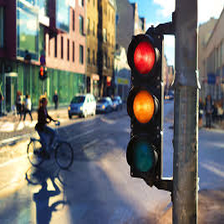

trafficlight


In [ ]:
road_sign_detection("/content/images (2).jpg", image_size)